# 과제1

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns
np.random.seed(123123)

In [278]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [279]:
X, y = mnist["data"], mnist["target"]

In [280]:
y = y.astype(np.uint8)

In [281]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [282]:
enc.fit(y[:,np.newaxis])

C:\Users\minki\AppData\Local\Temp\ipykernel_20780\4241405308.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  enc.fit(y[:,np.newaxis])


OneHotEncoder()

In [283]:
Y = enc.transform(y[:,np.newaxis]).toarray()

C:\Users\minki\AppData\Local\Temp\ipykernel_20780\752173705.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = enc.transform(y[:,np.newaxis]).toarray()


In [284]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]
X_train , X_val = X_train[:-10000] , X_train[-10000:]
y_train , y_val = y_train[:-10000] , y_train[-10000:]

In [285]:
print(X_train.shape,X_val.shape,X_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)


(50000, 784) (10000, 784) (10000, 784)
(50000, 10) (10000, 10) (10000, 10)


In [286]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [287]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [288]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1)))
    Y = B @ A
    return Y

In [289]:
def compute_cost(X, T, W, lambda_):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)

    # cross-entropy(sum x)
    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1))

    # L2
    L2_cost = 0.5 * lambda_ * np.sum(W**2).reshape(1,1)
    return cost , L2_cost

In [290]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

In [291]:
def batch_gd(X, T, W, learning_rate, iterations, batch_size ,lambda_=1, verbose=False):
    N = len(T)
    cost_history = np.zeros((iterations,2))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))

        # 가중치 계산
        W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch) + lambda_*W)

        loss , l2 = compute_cost(X_batch, T_batch, W , lambda_)
        cost_history[i] = loss + l2

        if i % 1000 == 0:
            learning_rate *= 0.95
            if verbose:
                print(cost_history[i][0])


    return (cost_history, W)

In [292]:
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))   # bias를 위한 1 추가
T = y_train

X_val = np.hstack((np.ones((np.size(X_val, 0),1)),X_val))
T_val = y_val
print(X.shape,X_val.shape)

lambda_range = np.logspace(np.log10(0.0001), np.log10(0.01), 10)
#lambda_range = [0.01,0.02,0.005,0.001]
lambda_acc = []

K = np.size(T, 1)
M = np.size(X, 1)
final_w = np.zeros((M,K))

for lambda_ in lambda_range:
    W = np.zeros((M,K))
    (cost_history, W_optimal) = batch_gd(X, T, W, 0.01, 50000, 64 , lambda_= lambda_,verbose=False)
    
   
    y_pred = predict(X_val, W_optimal)
    score = float(sum(y_pred == np.argmax(T_val, axis=1)))/ float(len(T_val))
    lambda_acc.append(score)
    if score == max(lambda_acc):
        final_w = W_optimal.copy()
    print("Lambda: {}, Validation Accuracy: {}".format(lambda_, score))

(50000, 785) (10000, 785)
Lambda: 0.0001, Validation Accuracy: 0.9155
Lambda: 0.0001668100537200059, Validation Accuracy: 0.9158
Lambda: 0.0002782559402207126, Validation Accuracy: 0.9165
Lambda: 0.00046415888336127773, Validation Accuracy: 0.9168
Lambda: 0.000774263682681127, Validation Accuracy: 0.916
Lambda: 0.001291549665014884, Validation Accuracy: 0.916
Lambda: 0.002154434690031882, Validation Accuracy: 0.9161
Lambda: 0.003593813663804626, Validation Accuracy: 0.9167
Lambda: 0.005994842503189409, Validation Accuracy: 0.9149
Lambda: 0.01, Validation Accuracy: 0.9143


In [296]:
best_lambda = lambda_range[np.argmax(lambda_acc)]
print("Best lambda: {} Acc: {}".format(best_lambda ,np.max(lambda_acc)))

Best lambda: 0.00046415888336127773 Acc: 0.9168


In [297]:
## Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, final_w)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.9156


# 과제2

원본 코드

training score : 0.995 (multinomial)
[[-4.51740321 -1.56048296]
 [-0.08918381  0.72635442]
 [ 4.60658703  0.83412854]]
[-1.69874938  2.89695153 -1.19820215]
training score : 0.976 (ovr)
[[-4.41615534 -2.23077034]
 [-0.36796618  1.64022091]
 [ 4.7027708   0.18133443]]
[-4.61020975 -1.91396323 -4.17213317]


C:\Users\minki\AppData\Local\Temp\ipykernel_20780\2277189836.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\minki\AppData\Local\Temp\ipykernel_20780\2277189836.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


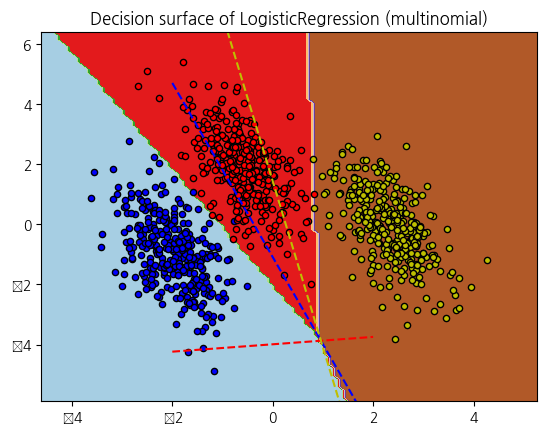

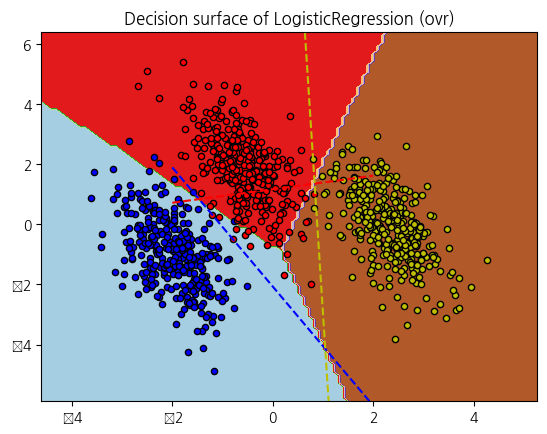

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for multi_class in ("multinomial", "ovr"):
    clf = LogisticRegression(
        solver="sag", max_iter=1000, random_state=42, multi_class=multi_class
    ).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf, X, response_method="predict", cmap=plt.cm.Paired, ax=ax
    )
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis("tight")

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
        )

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_
    print(coef)
    print(intercept)

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

        plt.plot([-2, 2], [line(-2), line(2)], ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()